In [1]:
import torch
import torchvision
import random
def check_cuda_support():
    cuda_available = torch.cuda.is_available()
    
    output_lines = [
        f"PyTorch version: {torch.__version__}",
        f"torchvision version: {torchvision.__version__}"
    ]
    
    if cuda_available:
        output_lines.append("CUDA is available. GPU support is enabled.")
        cuda_version = torch.version.cuda
        output_lines.append(f"CUDA version: {cuda_version}")
    
        gpu_name = torch.cuda.get_device_name(0)
        output_lines.append(f"GPU: {gpu_name}")
        num_gpus = torch.cuda.device_count()
        output_lines.append(f"Number of GPUs: {num_gpus}")
    else:
        output_lines.append("CUDA is not available. Running on CPU.")
    
    random.shuffle(output_lines)
    
    for line in output_lines:
        print(line)

if __name__ == "__main__":
    check_cuda_support()

/home/hasib/anaconda3/envs/deeplearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU: NVIDIA GeForce RTX 4050 Laptop GPU
PyTorch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121
CUDA version: 12.1
CUDA is available. GPU support is enabled.
Number of GPUs: 1


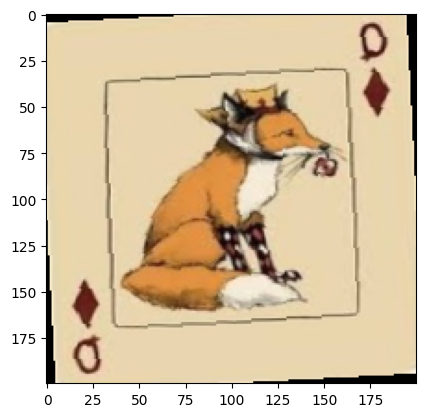

Label: queen of diamonds


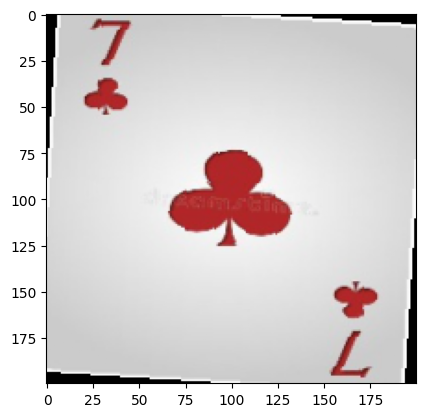

Label: seven of clubs


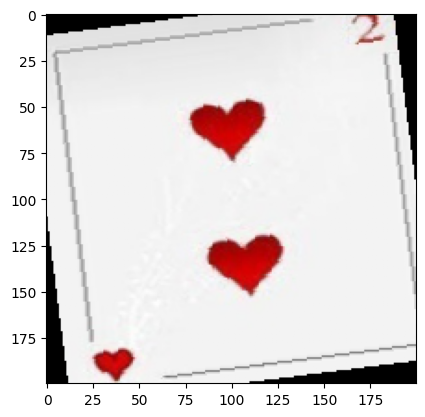

Label: two of hearts


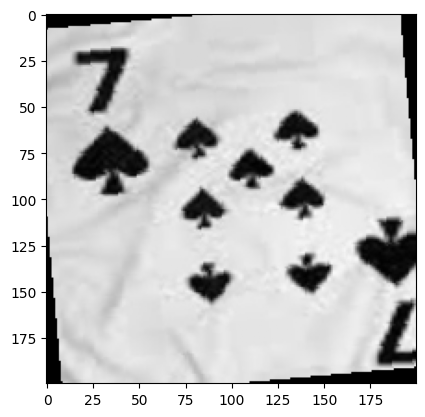

Label: seven of spades


In [3]:

from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
transform = transforms.Compose([
    
    transforms.Resize((200,200)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
    
    
])

train_dataset = datasets.ImageFolder(root='~/AI/torch/datasets/playing-Card/train', transform=transform)
test_dataset = datasets.ImageFolder(root='~/AI/torch/datasets/playing-Card/test', transform=transform)

train_loader =DataLoader(train_dataset, batch_size = 16, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle= True)

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    plt.imshow(img.permute(1, 2, 0))  # Change dimensions for plotting
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Shuffle the indices
indices = torch.randperm(images.size(0))

# Show the first 4 random images
for i in range(4):
    idx = indices[i]
    imshow(images[idx])
    print(f'Label: {train_dataset.classes[labels[idx]]}')


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 98 * 98, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) 
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [25]:
args = {
    'batch_size': 8,
    'test_batch_size': 16,
    'epochs': 20,
    'lr': 0.001,
    'gamma': 0.7,
    'no_cuda': False,
    'no_mps': False,
    'dry_run': False,
    'seed': 1,
    'log_interval': 5,
    'save_model': True
}

In [26]:
import torch.optim as optim

def train(model,device,train_loader,optimizer, epoch):
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output= model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            if args['dry_run']:
                break
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')
use_cuda = not args['no_cuda'] and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(args['seed'])

# Initialize model, optimizer, and loss function
num_classes = len(train_dataset.classes)
model = Net(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

# Training loop
for epoch in range(1, args['epochs'] + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/7624 (0%)]	Loss: 3.994577
Train Epoch: 1 [80/7624 (1%)]	Loss: 4.016020
Train Epoch: 1 [160/7624 (2%)]	Loss: 3.940967
Train Epoch: 1 [240/7624 (3%)]	Loss: 3.962245
Train Epoch: 1 [320/7624 (4%)]	Loss: 3.974498
Train Epoch: 1 [400/7624 (5%)]	Loss: 3.963181
Train Epoch: 1 [480/7624 (6%)]	Loss: 3.984943
Train Epoch: 1 [560/7624 (7%)]	Loss: 3.989810
Train Epoch: 1 [640/7624 (8%)]	Loss: 3.982302
Train Epoch: 1 [720/7624 (9%)]	Loss: 3.973141
Train Epoch: 1 [800/7624 (10%)]	Loss: 3.961532
Train Epoch: 1 [880/7624 (12%)]	Loss: 3.971641
Train Epoch: 1 [960/7624 (13%)]	Loss: 3.936585
Train Epoch: 1 [1040/7624 (14%)]	Loss: 3.972188
Train Epoch: 1 [1120/7624 (15%)]	Loss: 3.979636
Train Epoch: 1 [1200/7624 (16%)]	Loss: 3.968882
Train Epoch: 1 [1280/7624 (17%)]	Loss: 3.972307
Train Epoch: 1 [1360/7624 (18%)]	Loss: 3.932627
Train Epoch: 1 [1440/7624 (19%)]	Loss: 4.036788
Train Epoch: 1 [1520/7624 (20%)]	Loss: 4.004884
Train Epoch: 1 [1600/7624 (21%)]	Loss: 3.939174
Train Epoch: 1 [16

In [ ]:
torch.save(model.state_dict(), "playing_card_model.pt")
print("Model saved as playing_card_model.pt")


In [ ]:
# # CNN Improvement Summary: Hyperparameters and Techniques

# ## 1. Hyperparameters to Tweak

# ### 1.1 Learning Rate
# - Start with: 0.001
# - Try: [0.01, 0.0001, 0.00001]
# - Impact: Affects how quickly the model learns

# ### 1.2 Batch Size
# - Current: 16
# - Try: [8, 32, 64] (if memory allows)
# - Impact: Larger batches can lead to more stable gradients

# ### 1.3 Number of Epochs
# - Current: 30
# - Try: Increase to 50 or 100
# - Impact: More epochs allow more learning, but watch for overfitting

# ### 1.4 Optimizer
# - Current: Adam
# - Try: SGD with momentum, RMSprop
# - Impact: Different optimizers can lead to different convergence behaviors

# ### 1.5 Learning Rate Scheduler
# - Current: StepLR
# - Try: ReduceLROnPlateau, CosineAnnealingLR
# - Impact: Can help in finding better minima

# ### 1.6 Weight Decay (L2 Regularization)
# - Current: 1e-5
# - Try: [1e-4, 1e-6]
# - Impact: Helps prevent overfitting

# ## 2. Model Architecture Changes

# ### 2.1 Number of Convolutional Layers
# - Current: 2
# - Try: Add more layers (3 or 4)
# - Code change:
#   ```python
#   self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
#   self.bn3 = nn.BatchNorm2d(128)
#   ```

# ### 2.2 Number of Filters in Each Layer
# - Current: [32, 64]
# - Try: Increase (e.g., [64, 128, 256])
# - Code change:
#   ```python
#   self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
#   self.conv2 = nn.Conv2d(64, 128, 3, 1, padding=1)
#   ```

# ### 2.3 Fully Connected Layer Size
# - Current: 256
# - Try: Increase to 512 or 1024
# - Code change:
#   ```python
#   self.fc1 = nn.Linear(128 * 25 * 25, 512)
#   ```

# ### 2.4 Dropout Rate
# - Current: [0.25, 0.5]
# - Try: Adjust [0.3, 0.4] or [0.2, 0.3]
# - Code change:
#   ```python
#   self.dropout1 = nn.Dropout(0.3)
#   self.dropout2 = nn.Dropout(0.4)
#   ```

# ## 3. Data Augmentation Techniques

# ### 3.1 Increase Image Size
# - Current: 100x100
# - Try: 150x150 or 200x200 (if memory allows)
# - Code change:
#   ```python
#   transforms.Resize((150, 150))
#   ```

# ### 3.2 Add More Augmentations
# - Try: Add random crop, vertical flip
# - Code change:
#   ```python
#   transforms.RandomCrop(96),
#   transforms.RandomVerticalFlip(),
#   ```

# ### 3.3 Adjust Existing Augmentations
# - Increase rotation range, adjust color jitter
# - Code change:
#   ```python
#   transforms.RandomRotation(30),
#   transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
#   ```

# ## 4. Advanced Techniques

# ### 4.1 Transfer Learning
# - Use a pre-trained model (e.g., ResNet, VGG)
# - Code change:
#   ```python
#   model = torchvision.models.resnet18(pretrained=True)
#   model.fc = nn.Linear(model.fc.in_features, num_classes)
#   ```

# ### 4.2 Cross-Validation
# - Implement k-fold cross-validation
# - Code change: Wrap training loop in cross-validation split

# ### 4.3 Ensemble Methods
# - Train multiple models and combine predictions
# - Code change: Train multiple models, average their outputs

# ### 4.4 Focal Loss
# - Use for imbalanced datasets
# - Code change:
#   ```python
#   from torch.nn.functional import binary_cross_entropy_with_logits
  
#   def focal_loss(pred, target, gamma=2.0, alpha=0.25):
#       bce = binary_cross_entropy_with_logits(pred, target, reduction='none')
#       pt = torch.exp(-bce)
#       focal_loss = alpha * (1-pt)**gamma * bce
#       return focal_loss.mean()
#   ```

# ### 4.5 Mixed Precision Training
# - Use for faster training on compatible GPUs
# - Code change:
#   ```python
#   from torch.cuda.amp import autocast, GradScaler
  
#   scaler = GradScaler()
#   with autocast():
#       output = model(data)
#       loss = criterion(output, target)
#   scaler.scale(loss).backward()
#   scaler.step(optimizer)
#   scaler.update()
#   ```

# Remember to experiment with these changes systematically, 
# keeping track of the impact on model performance. It's often best to change one thing at a time to clearly understand its effect.



# 6GB VRAM Optimization: Code Changes and Parameter Adjustments

## 1. Model Architecture Changes

### 1.1 Simplified CNN Structure
# ```python
# class OptimizedNet(nn.Module):
#     def __init__(self, num_classes):
#         super(OptimizedNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(64 * 25 * 25, 256)  # Reduced from 512
#         self.fc2 = nn.Linear(256, num_classes)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout2(x)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)
# ```
# - Removed one convolutional layer
# - Reduced the size of the fully connected layer from 512 to 256

# ## 2. Training Parameters Adjustment

# ### 2.1 Batch Size Reduction
# ```python
# args = {
#     'batch_size': 16,  # Reduced from 32
#     'test_batch_size': 32,  # Reduced from 64
#     # ... other parameters ...
# }
# ```

# ### 2.2 Number of Epochs
# ```python
# args = {
#     # ... other parameters ...
#     'epochs': 30,  # Reduced from 50
#     # ... other parameters ...
# }
# ```

# ## 3. Data Preprocessing

# ### 3.1 Image Size Reduction
# ```python
# transform = transforms.Compose([
#     transforms.Resize((100, 100)),  # Reduced from 200x200
#     # ... other transforms ...
# ])
# ```

# ## 4. Data Loading Optimization

# ### 4.1 DataLoader Efficiency
# ```python
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, 
#     batch_size=args['batch_size'], 
#     shuffle=True, 
#     num_workers=2,  # Added for parallel data loading
#     pin_memory=True  # Added for faster data transfer to GPU
# )

# test_loader = torch.utils.data.DataLoader(
#     test_dataset, 
#     batch_size=args['test_batch_size'], 
#     shuffle=True, 
#     num_workers=2,
#     pin_memory=True
# )
# ```

# ## 5. Memory Management Best Practices

# ### 5.1 Explicit Garbage Collection (if needed)
# If you still experience memory issues, you can add this import and call it periodically:
# ```python
# import gc

# # After each epoch or when needed
# gc.collect()
# torch.cuda.empty_cache()
# ```

# ## 6. Summary of Key Changes

# 1. **Model Complexity**: Reduced from 3 conv layers to 2, and decreased FC layer size.
# 2. **Batch Size**: Decreased from 32 to 16 for training, 64 to 32 for testing.
# 3. **Image Size**: Reduced from 200x200 to 100x100.
# 4. **Training Duration**: Reduced epochs from 50 to 30.
# 5. **Data Loading**: Added `num_workers` and `pin_memory` for efficient GPU utilization.

# These changes collectively reduce the memory footprint of your model and 
# training process, allowing it to fit within the 6GB VRAM constraint while still maintaining learning capacity.